# phageParser - Analysis of Spacer Length Distribution across Organisms

C.K. Yildirim (cemyildirim@fastmail.com)

The latest version of this [IPython notebook](http://ipython.org/notebook.html) demo is available at [http://github.com/phageParser/phageParser](https://github.com/phageParser/phageParser/tree/django-dev/demos)

## Introduction

This demo uses the REST API of phageParser running locally to plot the distribution of spacer lengths.
In this case, the API is consumed using the requests library and the json responses are parsed for gathering
basepair length information of spacers.

In [84]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab

In [18]:
#Url of the phageParser API
apiurl = 'http://127.0.0.1:8000'

In [21]:
#Get the initial page for listing of accessible objects and get url for spacers
r=requests.get(apiurl)
spacerurl = r.json()['organisms']

In [22]:
#API is accessible by chunks of spacers that are in each page, get the total number of pages from meta field
r=requests.get(spacerurl)
last_page = r.json()['meta']['total_pages']

In [37]:
#Iterate through each page and store json response which only has length of spacers information
jbatches = []
for page in range(1,last_page):
    #Exclude every field on spacer object other than length and move to a certain page
    batch_url = spacerurl+'?page={}&exclude[]=*&include[]=loci.spacers.length'.format(page)
    spacer_batch = requests.get(batch_url).json()
    jbatches.append(spacer_batch)

In [71]:
org_spacer={}
for batch in jbatches:
    for organism in batch['organisms']:
        spacerlens = []
        if organism['loci'] == []:
            continue
        orgid = organism['loci'][0]['organism']    
        for locus in organism['loci']:
            for spacer in locus['spacers']:
                spacerlens.append(spacer['length'])
        org_spacer[orgid] = np.array(spacerlens)

In [83]:
#Get the global mean and variance
spacerbplengths = np.array([spacerlen for organism in org_spacer.values() for spacerlen in organism])
mu, sigma = spacerbplengths.mean(), spacerbplengths.std()
print("Calculated mean basepair length for spacers is {:.2f}+/-{:.2f}".format(mu,sigma))

Calculated mean basepair length for spacers is 35.10+/-3.93


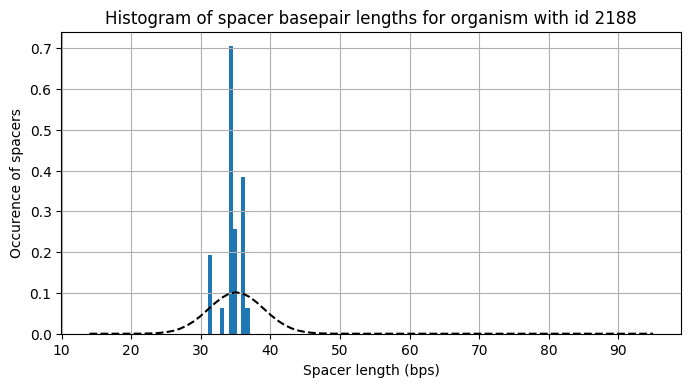

In [122]:
#Pick a random organism to plot the histogram with global distribution overlay
org_id = random.choice(list(org_spacer.keys()))
orgspacerlens = org_spacer[org_id]

fig, ax = plt.subplots(figsize=(8,4),dpi=100)
bins=10
#Plot histogram of spacer length frequency
ax.hist(orgspacerlens,bins=bins, normed=1)

#Plot normal distribution of length
x=np.unique(spacerbplengths)
y = mlab.normpdf(x, mu, sigma)
ax.plot(x, y, 'k--', linewidth=1.5, label='Global Distribution')

#format the figure and label
ax.grid(True)
ax.set_title("Histogram of spacer basepair lengths for organism with id {}".format(org_id))
ax.set_xlabel("Spacer length (bps)")
ax.set_ylabel("Occurence of spacers")
plt.show()

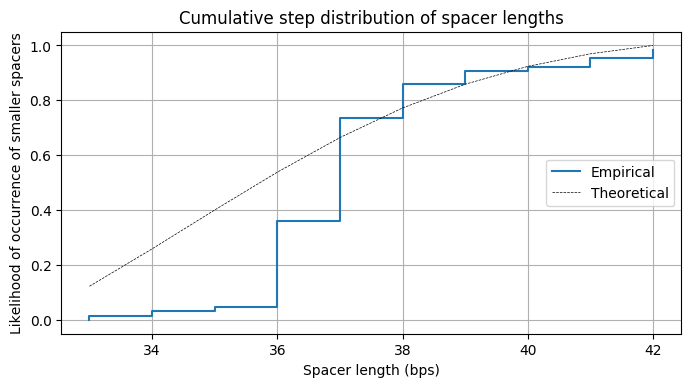

In [119]:
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
#Plot cumulative probability of data
sorted_data = np.sort(orgspacerlens)
ax.step(sorted_data, np.arange(sorted_data.size)/sorted_data.size, label='Empirical')
#Plot normal distribution
x=np.unique(sorted_data)
y = mlab.normpdf(x, mu, sigma).cumsum()
y /= y[-1]
ax.plot(x, y, 'k--', linewidth=0.5, label='Theoretical')

#Format the figure and label
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step distribution of spacer lengths')
ax.set_xlabel("Spacer length (bps)")
ax.set_ylabel('Likelihood of occurrence of smaller spacers')
plt.show()